<a href="https://colab.research.google.com/github/milicasopalovic/RI_rokovi/blob/main/50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://gitlab.com/milicasopalovic/emotion-detection.git

fatal: destination path 'emotion-detection' already exists and is not an empty directory.


In [8]:
import os

# Provera fajlova u kloniranom repozitorijumu
os.listdir('./emotion-detection')


['README.md', '.git', 'dataset']

In [9]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array, save_img, image_dataset_from_directory
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from collections import Counter
import cv2
import imghdr
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow import keras

In [10]:
import os
from collections import Counter

# Putanja do dataset-a
dataset_path = "./emotion-detection/dataset/train"

# Analiza distribucije klasa
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

print("Distribucija klasa:", class_counts)


Distribucija klasa: {'disgusted': 436, 'fearful': 4097, 'surprised': 3171, 'neutral': 4965, 'sad': 4830, 'happy': 7215, 'angry': 3995}


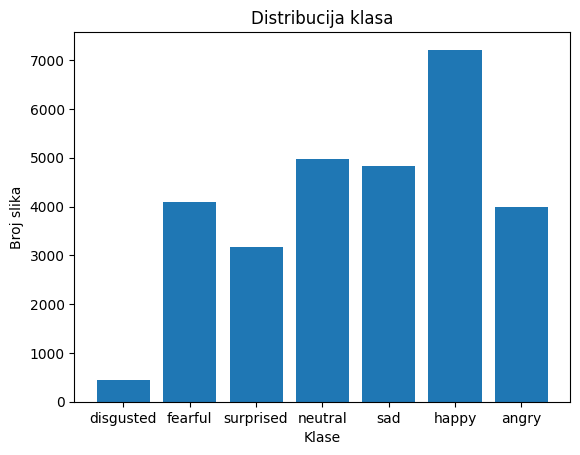

In [11]:
import matplotlib.pyplot as plt

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Distribucija klasa")
plt.xlabel("Klase")
plt.ylabel("Broj slika")
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentacija i podela trening podataka
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 20% trening podataka za validaciju
)

# Trening generator (80% trening podataka)
train_generator = train_datagen.flow_from_directory(
    "./emotion-detection/dataset/train",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    subset='training'  # Deo za treniranje
)

# Validacioni generator (20% trening podataka)
val_generator = train_datagen.flow_from_directory(
    "./emotion-detection/dataset/train",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    subset='validation'  # Deo za validaciju
)


test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    "./emotion-detection/dataset/test",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Težine klasa:", class_weights)

Težine klasa: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [14]:
input_shape=(48, 48, 1)
num_classes = 7

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Ovo je nedostajalo!


model = Sequential()

# Blok 1
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Blok 2
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Blok 3
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Blok 4
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

# Fully Connected
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 391,559 (1.49 MB)

 Trainable params: 390,599 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, BatchNormalization
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

callbacks = [early_stopping, reduce_lr]
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.3587 - loss: 1.7419 - val_accuracy: 0.3653 - val_loss: 1.7429 - learning_rate: 1.0000e-04
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.3615 - loss: 1.7394 - val_accuracy: 0.3088 - val_loss: 1.8675 - learning_rate: 1.0000e-04
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.3683 - loss: 1.7380 - val_accuracy: 0.4062 - val_loss: 1.7001 - learning_rate: 1.0000e-04
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.3621 - loss: 1.7362 - val_accuracy: 0.3675 - val_loss: 1.7373 - learning_rate: 1.0000e-04
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.3719 - loss: 1.7268 - val_accuracy: 0.3971 - val_loss: 1.6793 - learning_rate: 1.0000e-04
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.3757 - loss: 1.7056 - val_accuracy: 0.2965 - val_loss: 1.9147 - learning_rate: 1.0000e-04
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/ste

In [25]:
# Evaluacija modela na test podacima
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

# Prikaz rezultata
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4980 - loss: 1.4280
Test Loss: 1.406487226486206
Test Accuracy: 0.5044580698013306
